In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image
matplotlib.rcParams['figure.figsize'] = (9.0, 9.0) # This makes the images larger in the notebook


In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   

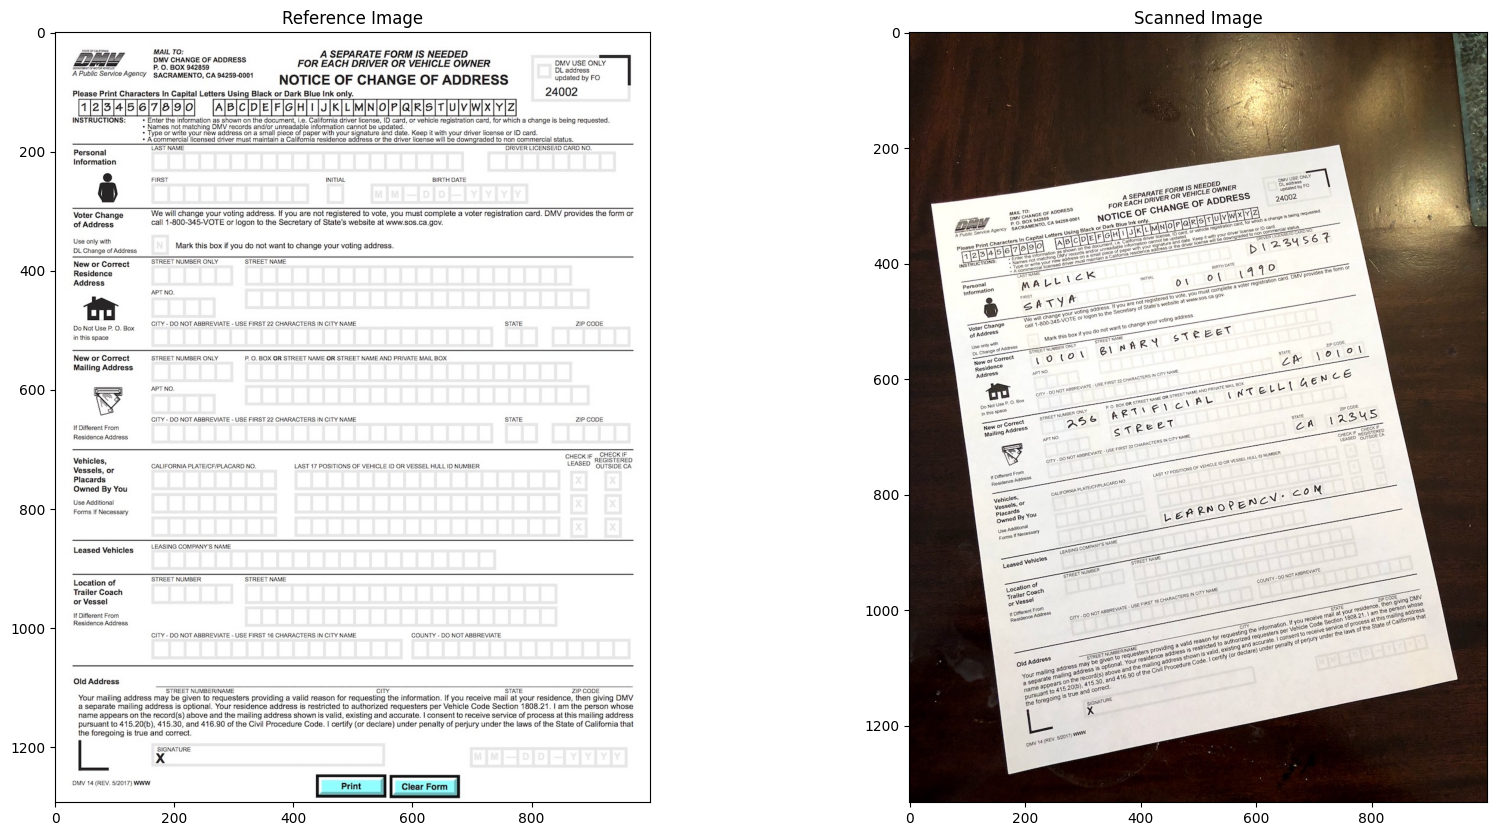

In [ ]:
refFileName = '../Photos/form.jpg'
im1 = cv.imread(refFileName, cv.IMREAD_COLOR_RGB)

imFileName = '../Photos/scanned-form.jpg'
im2 = cv.imread(imFileName, cv.IMREAD_COLOR_RGB)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title("Reference Image")
plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.title("Scanned Image")
plt.show()

In [4]:
im1_gray = cv.cvtColor(im1, cv.COLOR_RGB2GRAY)
im2_gray = cv.cvtColor(im2, cv.COLOR_RGB2GRAY)

MAX_FEATURES = 500
# Explination: ORB (Oriented FAST and Rotated BRIEF) is a fast robust feature detector and descriptor.
# It is used to find keypoints and descriptors in images.
orb = cv.ORB_create(MAX_FEATURES)
keyPoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keyPoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)
# Parameters:
# 1. NORM_HAMMING: This is the distance metric used to compare descriptors.
# 2. crossCheck: This is a boolean flag that indicates whether to perform cross-checking.

im1_display = cv.drawKeypoints(im1, keyPoints1, None, color=(0, 255, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv.drawKeypoints(im2, keyPoints2, None, color=(0, 255, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# This will draw the keypoints on the images.
# keypoints are the points of interest in the image that are detected by the ORB algorithm.
# Parameters:
# 1. im1: The first image.
# 2. keyPoints1: The keypoints detected in the first image.
# 3. None: This is the output image where the keypoints will be drawn.
# 4. color: The color of the keypoints.
# 5. flags: The flags that control how the keypoints are drawn.

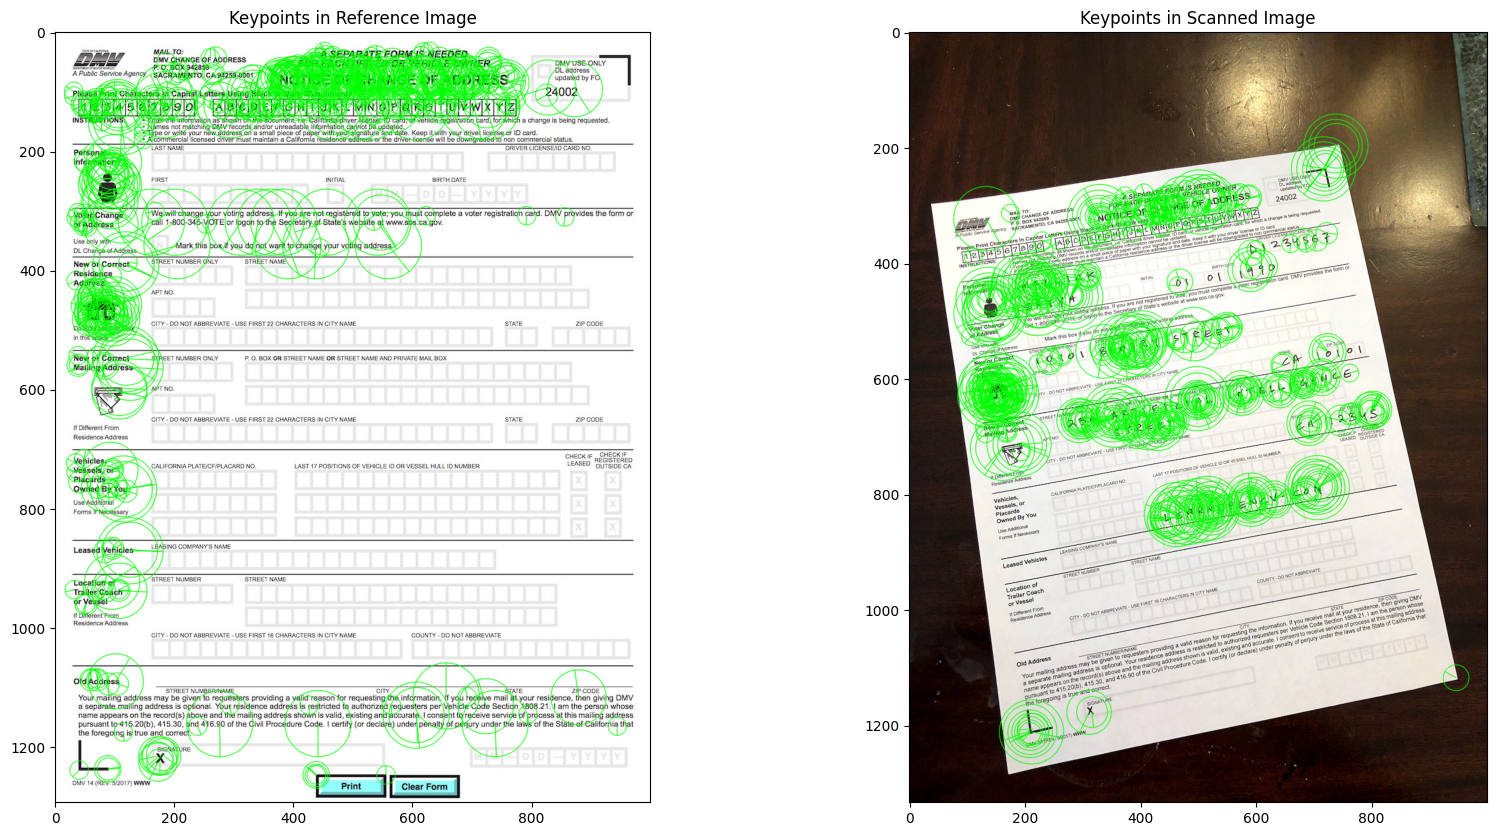

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1_display)
plt.title("Keypoints in Reference Image")
plt.subplot(1, 2, 2)
plt.imshow(im2_display)
plt.title("Keypoints in Scanned Image")
plt.show()

In [26]:
matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
# This will create a descriptor matcher that uses the brute force method with Hamming distance.
matches = list(matcher.match(descriptors1, descriptors2, None))
# This will match the descriptors of the two images.

matches.sort(key=lambda x: x.distance, reverse=False)
# This will sort the matches based on the distance between the descriptors.

numGoodMatches = int(len(matches) * 0.15)
# This will take the top 15% of the matches.
goodMatches = matches[:numGoodMatches]

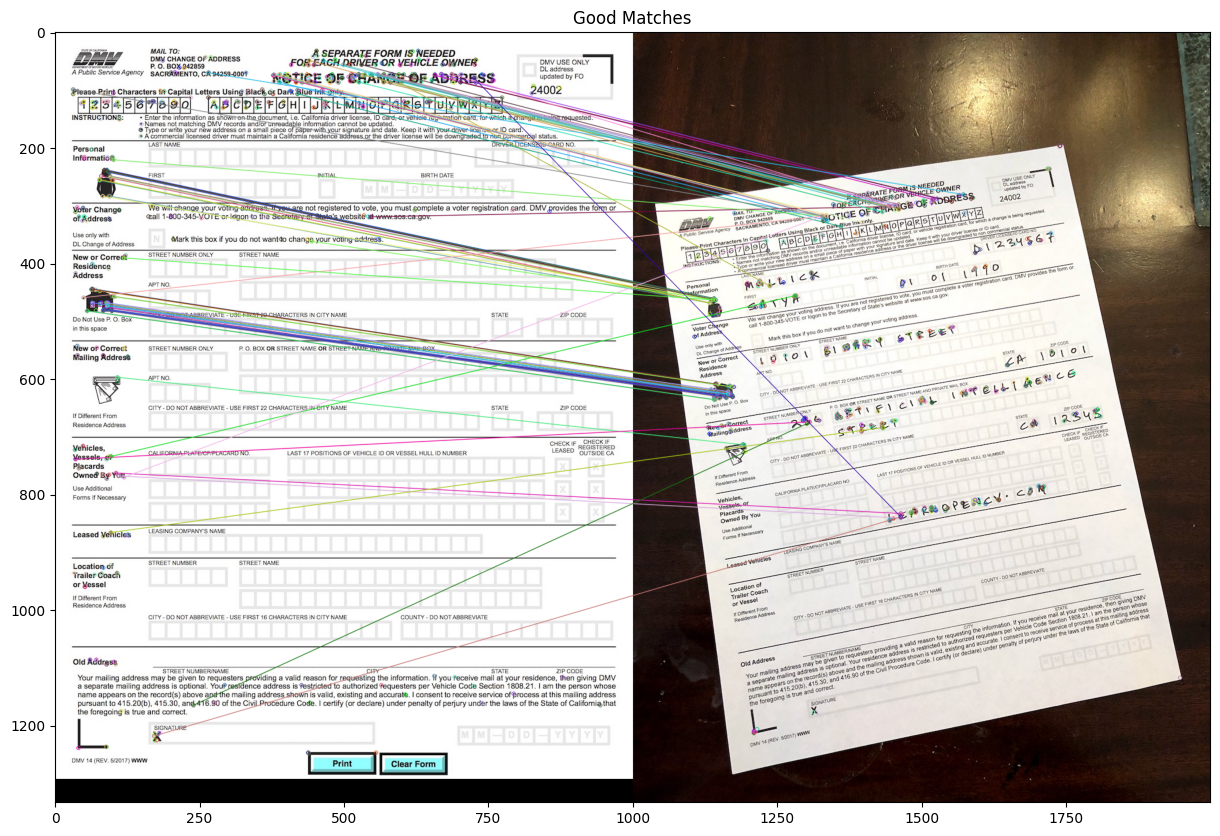

In [27]:
im_matches = cv.drawMatches(im1, keyPoints1, im2, keyPoints2, goodMatches, None)
# Parameters:
# 1. im1: The first image.
# 2. keyPoints1: The keypoints detected in the first image.
# 3. im2: The second image.
# 4. keyPoints2: The keypoints detected in the second image.
# 5. goodMatches: The good matches between the two images.
# 6. None: This is the output image where the matches will be drawn.
# 7. flags: The flags that control how the matches are drawn.
plt.figure(figsize=(40, 10))
plt.imshow(im_matches)
plt.title("Good Matches")
plt.show()

In [ ]:
# Find Homography
# Homography is a transformation that maps points from one plane to another.
# It is used to find the transformation between two images.
points1 = np.zeros((len(goodMatches), 2), dtype=np.float32)
points2 = np.zeros((len(goodMatches), 2), dtype=np.float32)

for i, match in enumerate(goodMatches):
    points1[i, :] = keyPoints1[match.queryIdx].pt
    # This will get the coordinates of the keypoint in the first image.
    points2[i, :] = keyPoints2[match.trainIdx].pt
    # This will get the coordinates of the keypoint in the second image.

h, mask = cv.findHomography(points2, points1, cv.RANSAC)    
# Parameters:
# First argument is the points that are matched in the second image.
# Second argument is the points that are matched in the first image.
# Third argument is the method used to find the homography. RANSAC is a robust method that can handle outliers.
# points2 before points1 because we want to find the transformation from the scanned image to the reference image.
# This will find the homography between the two sets of points.

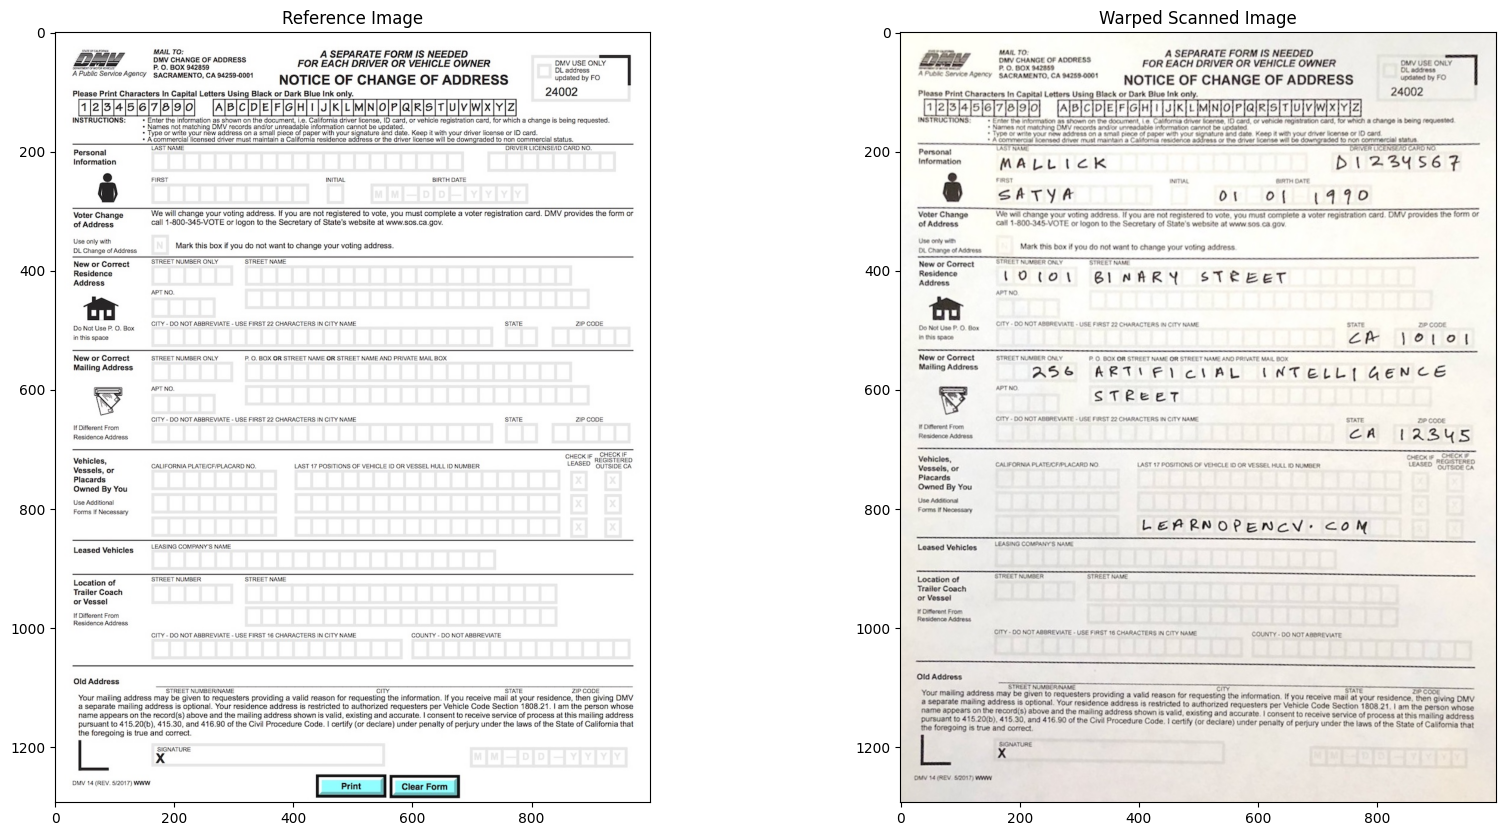

In [29]:
height, width, channels = im1.shape
im2_warped = cv.warpPerspective(im2, h, (width, height))
# warpPerspective used to apply the homography transformation to the first image.

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title("Reference Image")
plt.subplot(1, 2, 2)
plt.imshow(im2_warped)
plt.title("Warped Scanned Image")
plt.show()